# Problem definition

From description:

[SLICED](https://www.notion.so/SLICED-Show-c7bd26356e3a42279e2dfbafb0480073) is like the TV Show Chopped but for data science. Competitors get a never-before-seen dataset and two-hours to code a solution to a prediction challenge. Contestants get points for the best model plus bonus points for data visualization, votes from the audience, and more.

SLICED is streaming on Twitch Tuesdays at 8:30PM ET for twelve weeks starting June 1st: https://www.twitch.tv/nickwan_datasci.

![](https://gomesfellipe.github.io/img/2021/06/img1.png)

See the original post on my blog: https://gomesfellipe.github.io/post/2021-06-28-imbalanced-workflowsets/

# Solution

The [Bagged Decision Tree Models](https://bookdown.org/mpfoley1973/data-sci/bagged-trees.html) will be used (same presented by [Julia Silge](https://www.kaggle.com/juliasilge) in her (excellent) [blog post](https://juliasilge.com/blog/sliced-aircraft/)) together with several subsampling methods for unbalanced classes.

We will use the workflowsets package to optimize the data pipeline (both the method used and its hyperparameters). 

Methods considered:

- RANDOM OVERSAMPLING
- SMOTE - SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE
- ADASYN - ADAPTIVE SYNTHETIC SAMPLING
- UNDERSAMPLING
- NEAR MISS UNDERSAMPLING
- TOMEK LINKS UNDERSAMPLING

<br>

<p align="right"><span style="color:firebrick">Dont forget the upvote if you liked the notebook! <i class="fas fa-hand-peace"></i></span> </p>

# Load dependencies

In [1]:
library(tidyverse)    # ds toolkit
library(tidymodels)   # ml toolkit
library(baguette)     # bag_tree
library(themis)       # imbalanced
library(workflowsets) # opt pipelines
library(patchwork)    # arrange plots 

options(repr.plot.width=10, repr.plot.height=4, warn = -1)

doParallel::registerDoParallel()
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.7      ✔ rsample      0.1.0 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spe

Click below to see custom functions of this notebook

In [2]:
# Para o print de tabelas
print_table <- function(x, round=0, cv=F, wf=F, bm=F, ...){ 
  
  if(round>0) x <- x %>% mutate_if(is.numeric, ~round(.x, round))
  
  if(cv==T){
    columns_spec = list(
      .metric = reactable::colDef(minWidth = 75),
      .estimator = reactable::colDef(minWidth = 70),
      .config = reactable::colDef(minWidth = 120)
    )
  } else if(wf==T){
    columns_spec = list(
      wflow_id = reactable::colDef(minWidth = 100),
      .metric = reactable::colDef(minWidth = 100),
      preprocessor = reactable::colDef(minWidth = 110),
      rank = reactable::colDef(minWidth = 50),
      n = reactable::colDef(minWidth = 50)
    )
  }else if (bm==T){
    columns_spec = list(
      wflow_id = reactable::colDef(minWidth = 130),
      model = reactable::colDef(minWidth = 80)
    )
  }else{
    columns_spec = NULL
  }
  
  reactable::reactable(x, striped = T, bordered = T,
                       highlight = T, pagination = F, resizable = T, 
                       columns = columns_spec, ...)
  
}

# Para plot da matriz de confusao e distribuicoes de probabilidade
conf_mat_plot <- function(x, null_model = FALSE){
  p1 <- 
    x %>%
    select(.pred_class, damaged) %>%
    table() %>% 
    conf_mat() %>% 
    autoplot(type = "heatmap")+
    labs(title = "Matriz de confusão")
  
  p2 <- 
    x  %>%
    ggplot() +
    geom_density(aes(x = .pred_damage, fill = damaged), 
                 alpha = 0.5)+
    labs(title = "Distribuições de probabilidade previstas",
         subtitle = "por classe")+ 
    scale_x_continuous(limits = 0:1)+
    scale_fill_brewer(palette="Set1")
  
  p1 | p2
} 

In [3]:
df <- read_csv("../input/sliced-s01e02-xunyc5//train.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  id = col_double(),
  incident_year = col_double(),
  incident_month = col_double(),
  incident_day = col_double(),
  aircraft_model = col_double(),
  aircraft_mass = col_double(),
  engine_make = col_double(),
  engine_model = col_double(),
  engines = col_double(),
  engine1_position = col_double(),
  engine2_position = col_double(),
  engine3_position = col_double(),
  engine4_position = col_double(),
  height = col_double(),
  speed = col_double(),
  distance = col_double(),
  damaged = col_double()
)
ℹ Use `spec()` for the full column specifications.




# Prepare data

In [4]:
df <- df %>% 
  mutate(damaged = if_else(damaged==1, "damage", "not_damage") %>% 
           factor(levels = c("damage", "not_damage")))

In [5]:
p1 <- df %>% 
  count(damaged) %>% 
  ggplot(aes(x=rev(damaged), y=n, fill=damaged))+
  geom_bar(stat = "identity")+
  scale_fill_brewer(palette="Set1")+
  theme(legend.position = "bottom")+
  labs(y="Número de instâncias", x = "")

p2 <- df %>% 
  count(damaged) %>% 
  arrange(desc(damaged)) %>%
  mutate(prop = n / sum(n)) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop )%>% 
  ggplot(aes(x="", y=prop, fill=damaged)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  theme_void() + 
  theme(legend.position="none") +
  geom_text(aes(y = ypos,
                label = paste(scales::comma(n, big.mark = "."),
                              scales::comma(n/sum(n), big.mark = ".", 
                                            suffix = "%" ),sep = "\n")
                
  ), 
  color = "white", size=6) +
  scale_fill_brewer(palette="Set1")

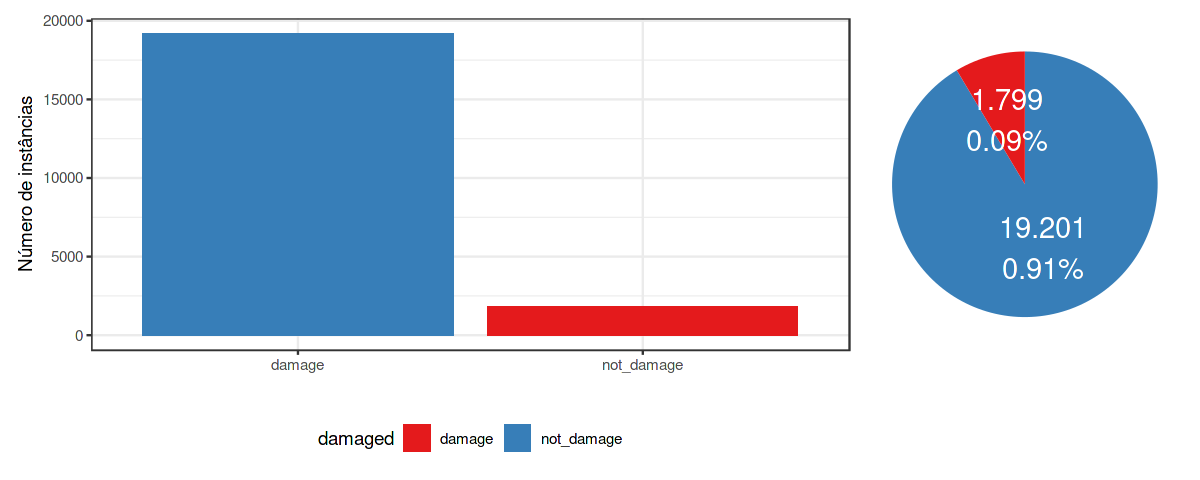

In [6]:
p1 + p2 

# Exploratory and Descriptive Analysis

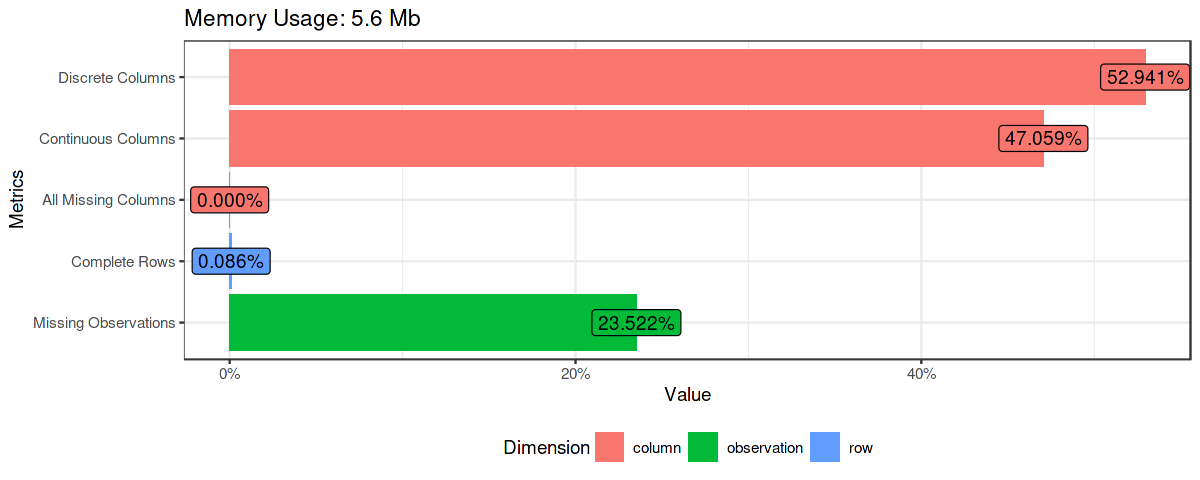

In [7]:
DataExplorer::plot_intro(df, ggtheme = theme_bw(), 
                         theme_config = list(legend.position = "bottom"))

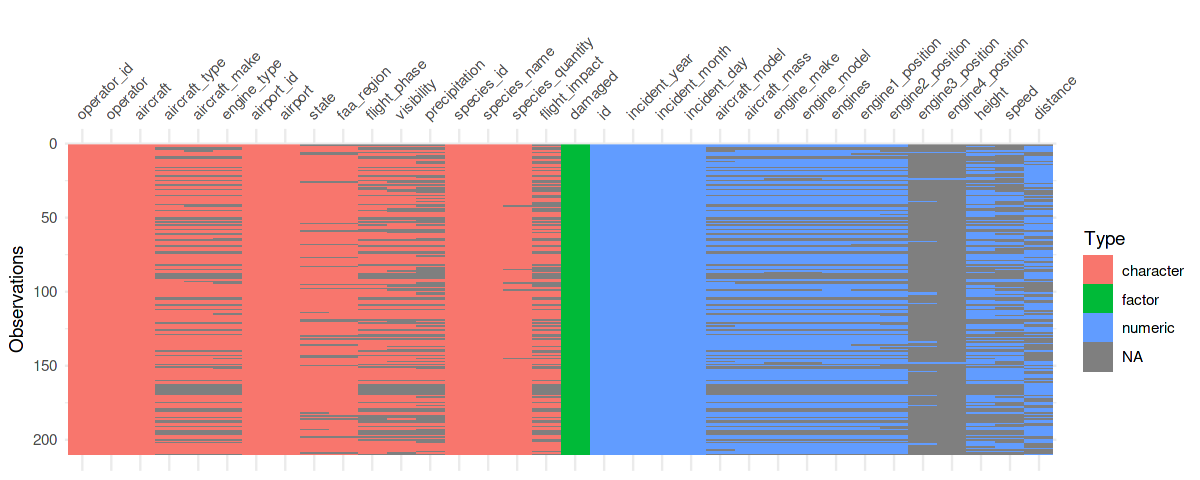

In [8]:
df %>% 
  sample_frac(0.01) %>% 
  visdat::vis_dat()

In [9]:
options(repr.plot.width=12, repr.plot.height=7, warn = -1)

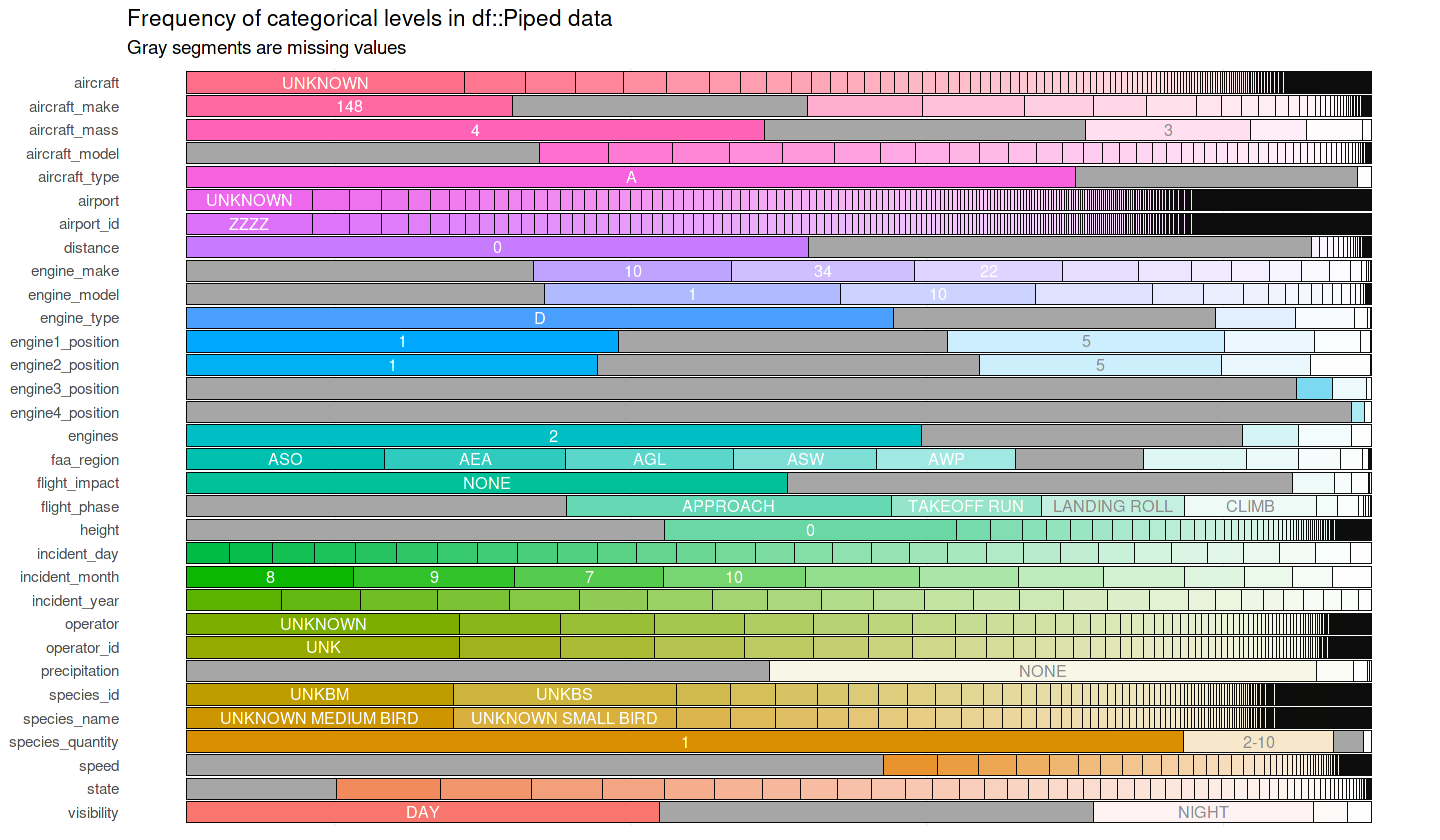

In [10]:
df %>%
  select(-damaged, -id)%>%
  mutate_all(as.factor) %>%
  inspectdf::inspect_cat() %>% 
  inspectdf::show_plot()

In [11]:
options(repr.plot.width=12, repr.plot.height=6, warn = -1)

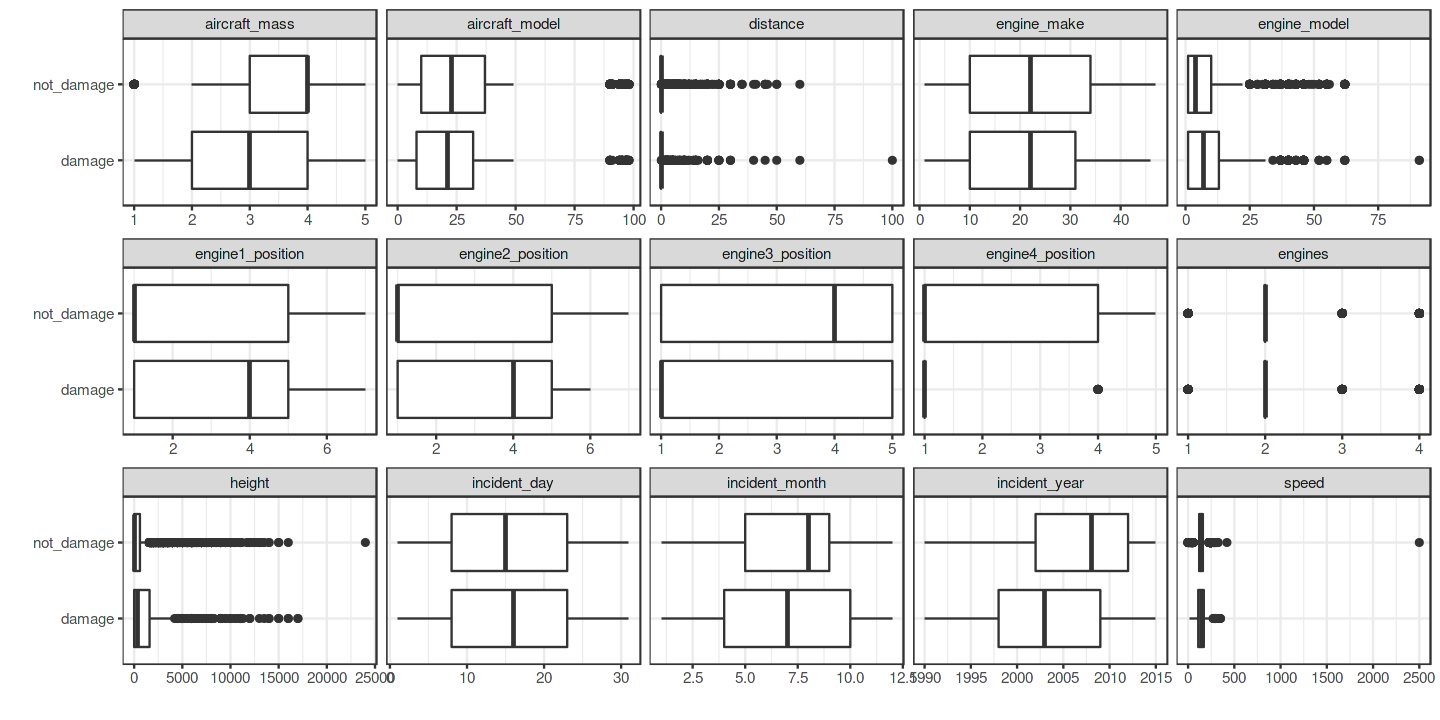

In [12]:
num_columns <- c(df %>% select_if(is.numeric) %>% colnames(), 'damaged')
df%>% 
  select_at(num_columns) %>% 
  select(-id) %>%
  gather(key, value, -damaged) %>%
  ggplot(aes(y=damaged, x=value))+
  geom_boxplot()+
  facet_wrap(~key, ncol=5, scales = "free_x")+
  labs(x = "", y="")

In [13]:
options(repr.plot.width=12, repr.plot.height=4, warn = -1)

# Model

In [14]:
set.seed(123)

bird_folds <- vfold_cv(df, v = 5, strata = damaged)
bird_metrics <- metric_set(mn_log_loss, accuracy, sensitivity, specificity)

In [15]:
bird_df <- df %>%
  select(
    damaged, flight_impact, precipitation,
    visibility, flight_phase, engines, incident_year,
    incident_month, species_id, engine_type,
    aircraft_model, species_quantity, height, speed
  )

In [16]:
base_rec <- recipe(damaged ~ ., data = bird_df) %>%
  step_novel(all_nominal_predictors()) %>%
  step_other(all_nominal_predictors(), threshold = 0.01) %>%
  step_unknown(all_nominal_predictors()) %>%
  step_impute_median(all_numeric_predictors()) %>%
  step_zv(all_predictors())

## Baselines

### Null Model

In [17]:
null_spec <- null_model(mode = "classification") %>% 
  set_engine("parsnip")

null_wf <-
  workflow() %>%
  add_recipe(base_rec) %>%
  add_model(null_spec)

null_rs <-
  fit_resamples(
    object = null_wf,
    resamples = bird_folds,
    metrics = bird_metrics,
    control = control_resamples(save_pred = TRUE)
  ) 

collect_metrics(null_rs)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9143333,5,0.002537027,Preprocessor1_Model1
mn_log_loss,binary,0.2924879,5,0.005986954,Preprocessor1_Model1
sens,binary,0.0000000,5,0.000000000,Preprocessor1_Model1
spec,binary,1.0000000,5,0.000000000,Preprocessor1_Model1


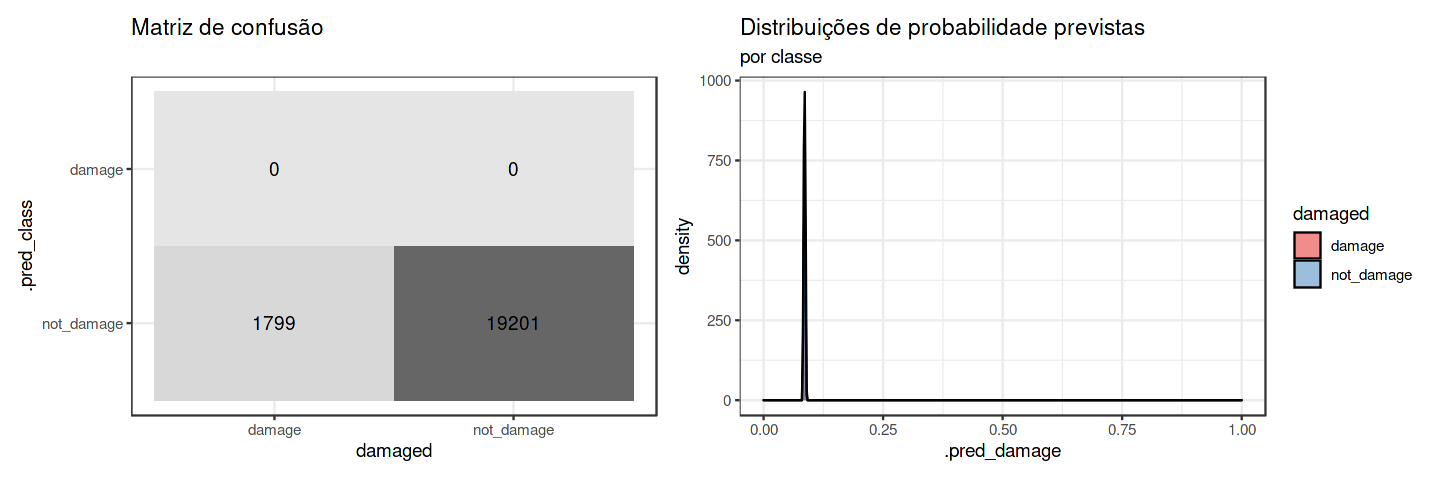

In [18]:
collect_predictions(null_rs) %>% 
  conf_mat_plot()

# Baseline Model

see: https://juliasilge.com/blog/sliced-aircraft/

In [19]:
bag_spec <-
  bag_tree(min_n = 10) %>%
  set_engine("rpart", times = 25) %>%
  set_mode("classification")

imb_wf <-
  workflow() %>%
  add_recipe(base_rec) %>%
  add_model(bag_spec)

set.seed(123)
imb_rs <-
  fit_resamples(
    imb_wf,
    resamples = bird_folds,
    metrics = bird_metrics,
    control = control_resamples(save_pred = TRUE)
  )

collect_metrics(imb_rs) 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9250952,5,0.0022062065,Preprocessor1_Model1
mn_log_loss,binary,0.2115165,5,0.0051056634,Preprocessor1_Model1
sens,binary,0.2778050,5,0.0094130794,Preprocessor1_Model1
spec,binary,0.9858384,5,0.0008425223,Preprocessor1_Model1


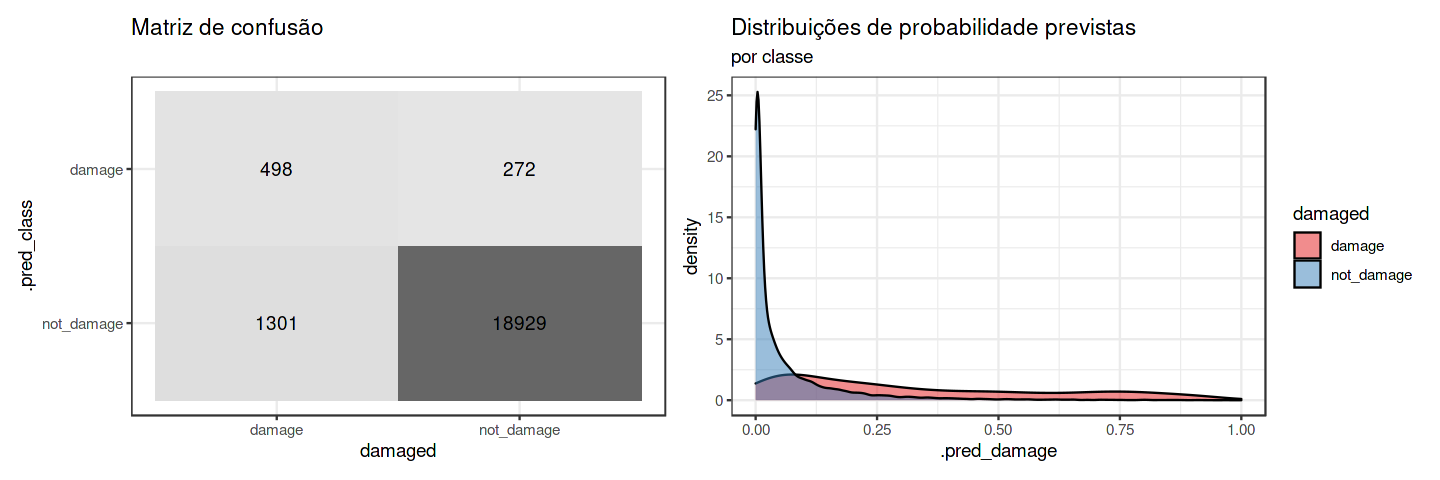

In [20]:
collect_predictions(imb_rs) %>% 
  conf_mat_plot()

# Prepare Pipelines with with `workflowsets`

## Oversampling

### Random Oversampling

In [21]:
rec_up <- base_rec %>% 
  step_upsample(damaged, over_ratio = tune())

params_up <- rec_up %>% 
  parameters() %>% update(over_ratio = mixture(c(0.5, 1)))

### Smote - Synthetic Minority Oversampling Technique

In [22]:
rec_smote <- base_rec %>%
  step_dummy(all_nominal_predictors()) %>%
  step_smote(damaged, over_ratio = tune(), 
             neighbors = tune())

params_smote <- rec_smote %>% 
  parameters() %>% update(over_ratio = mixture(c(0.5, 1)),
                          neighbors = neighbors())

### Adasyn - Adaptive Synthetic Sampling

In [23]:
rec_adasyn <- base_rec %>%
  step_dummy(all_nominal_predictors()) %>%
  step_adasyn(damaged, 
              over_ratio = tune(), 
              neighbors = tune())

params_adasyn <- rec_adasyn %>% 
  parameters() %>% update(over_ratio = mixture(c(0.5, 1)),
                          neighbors = neighbors())

## Undersampling

### Random Undersampling

In [24]:
rec_down <- base_rec %>% 
  step_downsample(damaged, under_ratio = tune())

params_down <- rec_down %>% 
  parameters() %>% update(under_ratio = deg_free())

### Near Miss Undersampling

In [25]:
rec_nearmiss <- base_rec %>%
  step_dummy(all_nominal_predictors()) %>%
  step_nearmiss(damaged, 
                under_ratio = tune(), 
                neighbors = tune())

params_nearmiss <- rec_nearmiss %>% 
  parameters() %>% update(under_ratio = deg_free(),
                          neighbors = neighbors())

### Tomek Links Undersampling

In [26]:
rec_tomek <- base_rec %>%
  step_dummy(all_nominal_predictors()) %>%
  step_tomek(damaged)

## Prepare Pipeline

In [27]:
chi_models <- 
  workflow_set(
    preproc = list(upsample = rec_up,
                   smote = rec_smote,
                   adasyn = rec_adasyn,
                   downsample = rec_down,
                   nearmiss = rec_nearmiss,
                   tomek = rec_tomek),
    models = list(bag_spec = bag_spec),
    cross = TRUE
  )

In [28]:
chi_models <- chi_models %>% 
  option_add(param_info = params_up, id = "upsample_bag_spec")  %>% 
  option_add(param_info = params_smote, id = "smote_bag_spec") %>% 
  option_add(param_info = params_adasyn, id = "adasyn_bag_spec") %>% 
  option_add(param_info = params_down, id = "downsample_bag_spec") %>% 
  option_add(param_info = params_nearmiss, id = "nearmiss_bag_spec")

In [29]:
set.seed(123)
chi_models <- 
  chi_models %>% 
  workflow_map("tune_grid",
               resamples = bird_folds, 
               grid = 5, 
               metrics = bird_metrics,
               control = control_resamples(save_pred = TRUE),
               verbose = TRUE)

i 1 of 6 tuning:     upsample_bag_spec

✔ 1 of 6 tuning:     upsample_bag_spec (4m 50s)

i 2 of 6 tuning:     smote_bag_spec

✔ 2 of 6 tuning:     smote_bag_spec (8m 26.2s)

i 3 of 6 tuning:     adasyn_bag_spec

✔ 3 of 6 tuning:     adasyn_bag_spec (8m 46s)

i 4 of 6 tuning:     downsample_bag_spec

✔ 4 of 6 tuning:     downsample_bag_spec (2m 55s)

i 5 of 6 tuning:     nearmiss_bag_spec

✔ 5 of 6 tuning:     nearmiss_bag_spec (4m 5.1s)

i	No tuning parameters. `fit_resamples()` will be attempted

i 6 of 6 resampling: tomek_bag_spec

✔ 6 of 6 resampling: tomek_bag_spec (1m 13.7s)



In [30]:
rank_results(chi_models, rank_metric = "mn_log_loss", select_best = TRUE) %>% 
  select(-.config) %>%
  mutate(wflow_id = str_remove(wflow_id, "_bag_spec")) %>% 
  print_table(round = 5, wf=T, height = 300, filterable = T)

HTML widgets cannot be represented in plain text (need html)

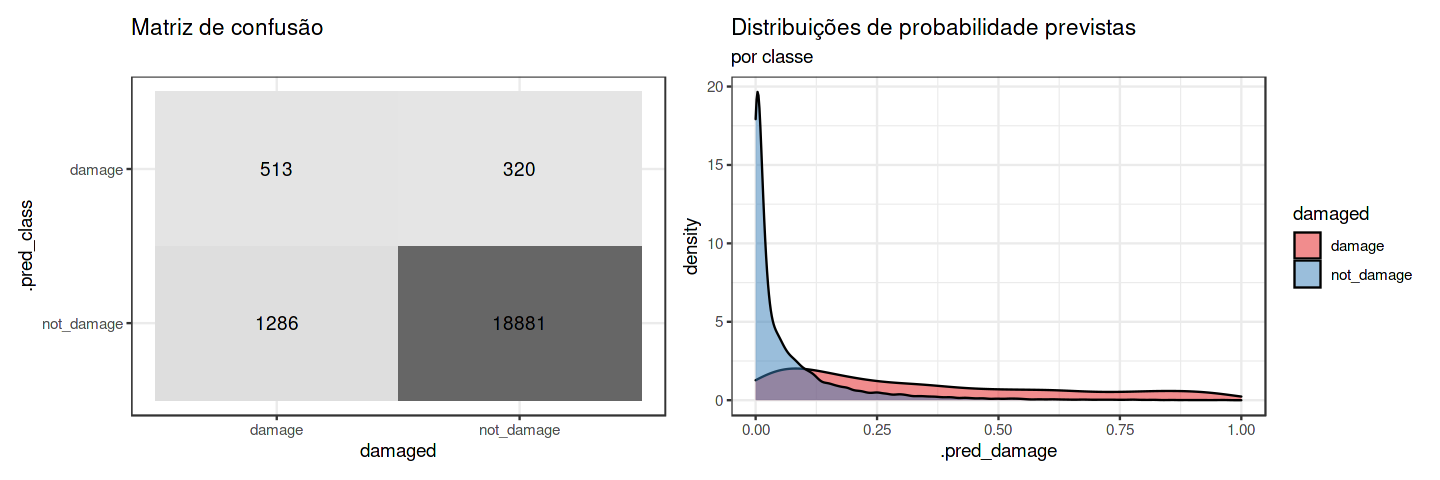

In [31]:
collect_predictions(chi_models) %>% 
  filter(wflow_id == "tomek_bag_spec") %>% 
  conf_mat_plot()

# Benchmark

In [32]:
benchmark <- bind_rows(
  mutate(collect_metrics(null_rs), wflow_id = "default", model = "null_model") %>% 
    select(.metric, mean, wflow_id, model) %>% 
    spread(.metric, mean)
  ,
  mutate(collect_metrics(imb_rs), wflow_id = "default", model = "bag_tree") %>% 
    select(.metric, mean, wflow_id, model) %>% 
    spread(.metric, mean)
  ,
  rank_results(chi_models, rank_metric = "mn_log_loss", select_best = TRUE) %>% 
    filter(wflow_id=="smote_bag_spec") %>% 
    select(.metric, mean, wflow_id, model) %>% 
    spread(.metric, mean)
  ,
  rank_results(chi_models, rank_metric = "mn_log_loss", select_best = TRUE) %>% 
    filter(rank==1) %>% 
    select(.metric, mean, wflow_id, model) %>% 
    spread(.metric, mean)
) 

In [33]:
benchmark

wflow_id,model,accuracy,mn_log_loss,sens,spec
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
default,null_model,0.9143333,0.2924879,0.0000000,1.0000000
default,bag_tree,0.9250952,0.2115165,0.2778050,0.9858384
smote_bag_spec,bag_tree,0.9217143,0.2179995,0.3030424,0.9798097
tomek_bag_spec,bag_tree,0.9235238,0.2148458,0.2855648,0.9833385


# Sub

In [34]:
test <- read_csv("../input/sliced-s01e02-xunyc5//test.csv")
sub <- read_csv("../input/sliced-s01e02-xunyc5//sample_submission.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  id = col_double(),
  incident_year = col_double(),
  incident_month = col_double(),
  incident_day = col_double(),
  aircraft_model = col_double(),
  aircraft_mass = col_double(),
  engine_make = col_double(),
  engine_model = col_double(),
  engines = col_double(),
  engine1_position = col_double(),
  engine2_position = col_double(),
  engine3_position = col_double(),
  engine4_position = col_double(),
  height = col_double(),
  speed = col_double(),
  distance = col_double()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  id = col_double(),
  damaged = col_double()
)




## Baseline

In [35]:
final_model_baseline <- fit(imb_wf, bird_df)

In [36]:
sub <- sub %>% 
    select(id) %>%
    bind_cols(
        predict(final_model_baseline, test, type = "prob") %>% 
            rename_all(~str_remove(.x, "\\.pred_"))
        ) %>%
    select(-not_damage) %>%
    rename(damaged = damage)

In [37]:
write_csv(sub, 'sub_baseline.csv')

## Tuned model

In [38]:
best_workflow <- 
  chi_models %>% 
  pull_workflow('tomek_bag_spec')

final_parameters <- 
  chi_models %>% 
  filter(wflow_id == 'tomek_bag_spec') %>% pull(result) %>% .[[1]] %>%
  select_best("mn_log_loss")

best_workflow <- best_workflow %>% finalize_workflow(final_parameters)

In [39]:
final_model_tomek <- fit(best_workflow, bird_df)

In [40]:
sub <- sub %>% 
    select(id) %>%
    bind_cols(
        predict(final_model_tomek, test, type = "prob") %>% 
            rename_all(~str_remove(.x, "\\.pred_"))
        ) %>%
    select(-not_damage) %>%
    rename(damaged = damage)

In [41]:
write_csv(sub, 'sub_tomek.csv')

# Conclusion

Just as there is no better model, there is no better data balancing technique. Therefore, for best results, we can try to optimize which approach will be used and also its hyperparameters (together with the hyperparameters of the models in question).

This approach in R is new to me (I'm more used to using Python with the `sklearn.pipeline.Pipeline` method in conjunction with the `imblearn` library) so any criticism and suggestions for improvement will be very welcome! Just get in touch or leave it here in the comments!

Good studies and I hope you like it! 🚀

# Sources

- https://www.tidyverse.org/blog/2021/03/workflowsets-0-0-1/
- https://www.kaggle.com/c/sliced-s01e02-xunyc5
- https://juliasilge.com/blog/sliced-aircraft/
- https://topepo.github.io/caret/subsampling-for-class-imbalances.html
- https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
- https://machinelearningmastery.com/what-is-imbalanced-classification/
- https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/
- https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/